In [1]:
%matplotlib notebook

In [2]:
#Importing necessary packages

import pandas as pd
import numpy as np
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab
import re
from matplotlib.lines import Line2D  # for legend handle
from tqdm import tqdm

In [3]:
kpi_df = pd.read_csv('ranking kpi.csv')
kpi_df.sort_values('kpi',inplace=True, ascending=False)
kpi_df.reset_index(inplace=True, drop=True)

pbar = tqdm(total=len(kpi_df))
for index, row in kpi_df.iterrows():
    filename = f'{re.sub("[^0-9]", "", row["CNPJ_FUNDO"])}.csv'
    nome = row['nomeAbreviado']
    
    cnpj_desempenho = pd.read_csv(f'CNPJ Desempenho/{filename}')
    if index == 0:
        cotas_df = pd.DataFrame()
        cotas_df['DT_COMPTC'] = cnpj_desempenho['DT_COMPTC']
        cotas_df[nome] = cnpj_desempenho['VL_QUOTA']
    else: 
        cotas_df = pd.merge(cotas_df, cnpj_desempenho[['DT_COMPTC', 'VL_QUOTA']], on='DT_COMPTC', how='left')
        cotas_df.rename(columns={'VL_QUOTA': nome}, inplace=True)
    pbar.update()

cotas_df = cotas_df.dropna(how='any',axis=0) 

100%|██████████████████████████████████████████████████████████████████████████████| 1571/1571 [02:28<00:00,  8.96it/s]

In [4]:
ibov = pd.read_csv('ibov.csv')
ibov = ibov[['Date', 'Adj Close']]
ibov.columns = ['DT_COMPTC', 'IBOV']
ibov['DT_COMPTC'] = pd.to_datetime(ibov['DT_COMPTC'])

cotas_df['DT_COMPTC'] = pd.to_datetime(cotas_df['DT_COMPTC'])
cotas_df = pd.merge(cotas_df, ibov, on='DT_COMPTC', how='left')
cotas_df = cotas_df.dropna(how='any',axis=0) 

In [5]:
cotas_df.to_csv('cotas_for_graph.csv', index=False)

In [6]:
def volatility(df):
    dr = daily_returns(df)
    return dr.std()

def sharpe (ret,vol):
    return ret/vol

In [7]:
df1 = cotas_df.set_index('DT_COMPTC')

In [8]:
#Calculate daily changes in the stocks' value
df2 = df1.pct_change()
#Remove nan values at the first row of df2. Create a new dataframe df
daily_return = df2.iloc[1:len(df2.index),:]
# Calculate annualized average return for each stock. Annualized average return = Daily average return * 252 business days.
annualized_return_list = np.mean(daily_return,axis=0)*252

volatility_list = np.std(daily_return, axis=0) *np.sqrt(252)

sharpe_list = sharpe(annualized_return_list, volatility_list)

classe_list = kpi_df[['nomeAbreviado', 'classe']]
classe_list.loc[classe_list['classe'] == '0', ['classe']] = 'Outros'
classe_list = classe_list.set_index('nomeAbreviado', drop=True)
classe_list = classe_list.iloc[:,0]
classe_list['IBOV'] = 'IBOV'

kpi_value = kpi_df[['nomeAbreviado', 'kpi']]
kpi_value = kpi_value.set_index('nomeAbreviado', drop=True)
kpi_value = kpi_value.iloc[:,0]
kpi_value['IBOV'] = None


c:\python39\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\python39\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [9]:
volatility_list

COUGAR FIC FIA                                     0.274610
SANTANDER FI COLABORADORES MAGAZINE LUIZA AÇÕES    0.504782
FIC FIM CP VIC CPHY                                0.004706
BB CAMBIAL DÓLAR LP VIP FIC FI                     0.165315
ORGANON FIC FIA                                    0.291285
                                                     ...   
NEXT FIC FI RF ATIVO                               0.011231
BB AÇÕES SAÚDE E BEM ESTAR FIC FI                  0.287878
MAUA MACRO ADVISORY FIC FIM                        0.071445
FIDUC FIC FI RF CP LP                              0.037491
IBOV                                               0.286910
Length: 1572, dtype: float64

In [10]:
names_list = volatility_list.index.to_list()

i = 0
while i < len(names_list):
    names_list[i] = f' {kpi_value[i]}, {names_list[i]}'
    i+=1

In [11]:
plt.style.use('default')


<IPython.core.display.Javascript object>


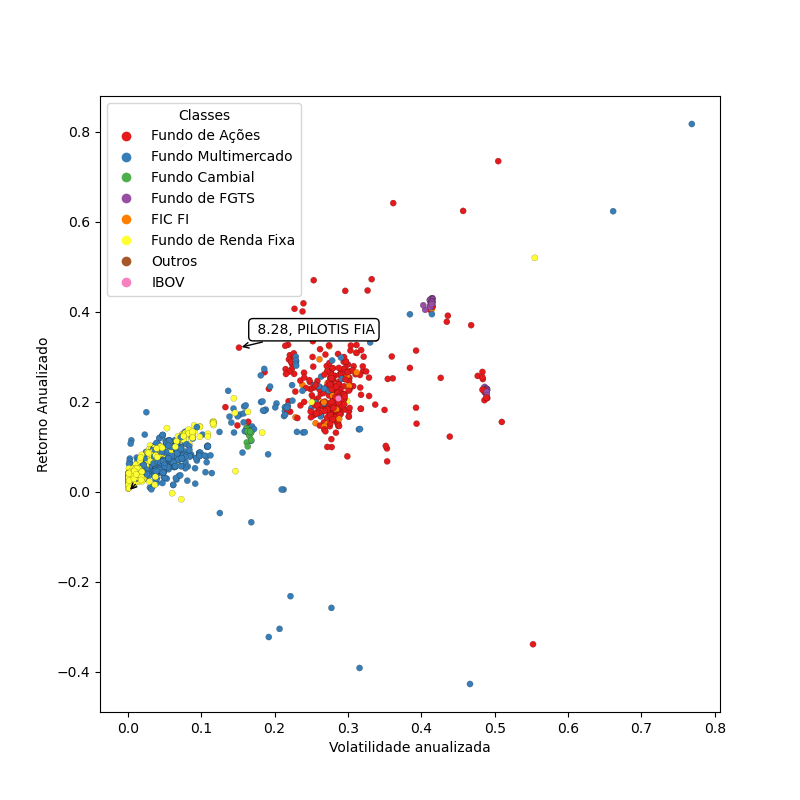

In [12]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

x = volatility_list
y = annualized_return_list

names = np.array(names_list)


colors = {'Fundo de Ações':plt.cm.Set1(0), 
         'Fundo Multimercado':plt.cm.Set1(1),
         'Fundo Cambial':plt.cm.Set1(2),
         'Fundo de FGTS':plt.cm.Set1(3),
         'FIC FI':plt.cm.Set1(4),
         'Fundo de Renda Fixa':plt.cm.Set1(5),
         'Outros':plt.cm.Set1(6),
         'IBOV':plt.cm.Set1(7)}

c = classe_list.map(colors)

norm = plt.Normalize(1,4)
cmap = plt.cm.RdYlGn

fig,ax = plt.subplots(figsize=(8,8))
sc = plt.scatter(x,y,c=c, s=20, edgecolors='black', linewidths=0.1)

handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=v, label=k, markersize=8) for k, v in colors.items()]

ax.legend(title='Classes', handles=handles, bbox_to_anchor=(0, 1), loc='upper left')


annot = ax.annotate("", xy=(0,0), xytext=(10,10), textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(True)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(" ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(True)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)
plt.xlabel('Volatilidade anualizada')
plt.ylabel('Retorno Anualizado')


plt.show()

<IPython.core.display.Javascript object>


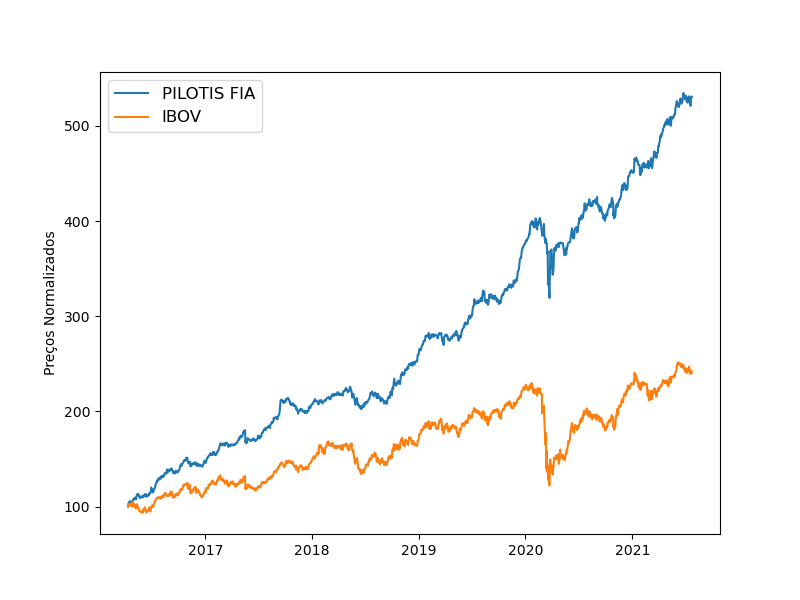

In [13]:
kpi_df = pd.read_csv('ranking kpi.csv')

kpi_acoes_df = kpi_df.loc[((kpi_df.nomeAbreviado == 'PILOTIS FIA'))]
kpi_acoes_df.reset_index(inplace=True, drop=True)

for index, row in kpi_acoes_df.iterrows():
    filename = f'{re.sub("[^0-9]", "", row["CNPJ_FUNDO"])}.csv'
    nome = row['nomeAbreviado']
    
    cnpj_desempenho = pd.read_csv(f'CNPJ Desempenho/{filename}')
    if index == 0:
        cotas_df = pd.DataFrame()
        cotas_df['DT_COMPTC'] = cnpj_desempenho['DT_COMPTC']
        cotas_df[nome] = cnpj_desempenho['VL_QUOTA']
    else: 
        cotas_df = pd.merge(cotas_df, cnpj_desempenho[['DT_COMPTC', 'VL_QUOTA']], on='DT_COMPTC', how='left')
        cotas_df.rename(columns={'VL_QUOTA': nome}, inplace=True)

cotas_df = cotas_df.dropna(how='any',axis=0) 

ibov = pd.read_csv('ibov.csv')
ibov = ibov[['Date', 'Adj Close']]
ibov.columns = ['DT_COMPTC', 'IBOV']

cotas_df = pd.merge(cotas_df, ibov, on='DT_COMPTC', how='left')
cotas_df.fillna(method='ffill', inplace=True)
cotas_df['DT_COMPTC'] = pd.to_datetime(cotas_df['DT_COMPTC'])
df1 = cotas_df.set_index('DT_COMPTC')

df3 = df1.divide(df1.iloc[0] / 100)

plt.figure(figsize=(8, 6))
for i in range(df3.shape[1]):
    plt.plot(df3.iloc[:,i], label=df3.columns.values[i])
plt.legend(loc='upper left', fontsize=12)



plt.ylabel('Preços Normalizados')

plt.show()



<IPython.core.display.Javascript object>


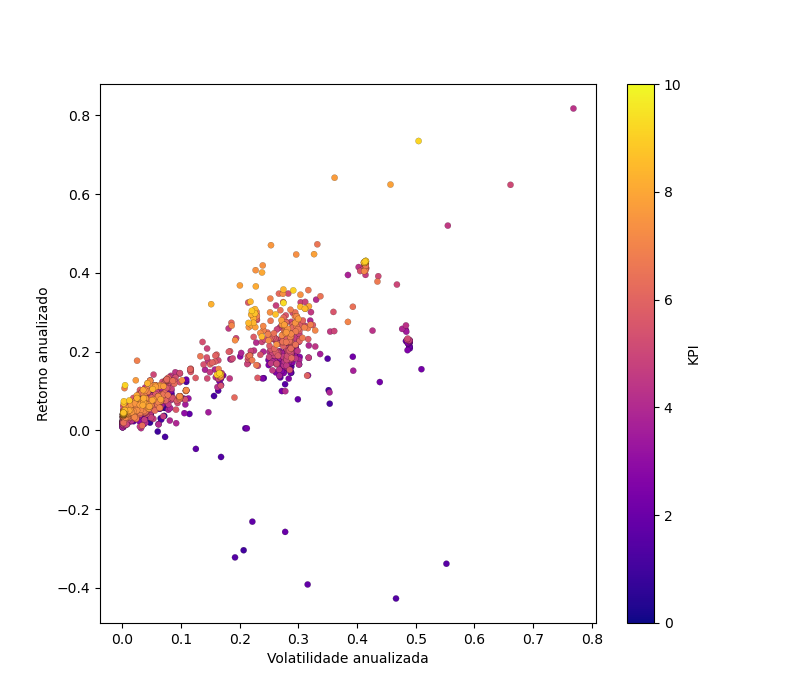

In [14]:
ret_arr = annualized_return_list.iloc[::-1]
vol_arr = volatility_list.iloc[::-1]


    
kpi_arr = kpi_value.iloc[::-1]

plt.figure(figsize=(8,7))
plt.scatter(vol_arr, ret_arr, c=kpi_arr, cmap='plasma', s=20, edgecolors='black', linewidths=0.1, vmin=0, vmax=10)

annot = ax.annotate("", xy=(0,0), xytext=(10,10),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(True)

def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(" ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(True)
                fig.canvas.draw_idle()

fig.canvas.mpl_connect("motion_notify_event", hover)

plt.colorbar(label='KPI')
plt.xlabel('Volatilidade anualizada')
plt.ylabel('Retorno anualizado')
plt.show()